<a href="https://colab.research.google.com/github/bimarshak7/liver-cirrhosis-prediction/blob/main/cirrhosis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cirrhosis Prediction

**SCENARIO**  
Cirrhosis is a chronic liver disease that occurs when healthy liver tissue is replaced by scar tissue, leading to a progressive loss of liver function. The scar tissue that forms in the liver can block blood flow through the liver and prevent it from working properly.Cirrhosis can have a number of causes, including chronic hepatitis B or C, alcohol abuse, nonalcoholic fatty liver disease, and autoimmune disorders. Symptoms of cirrhosis can include fatigue, jaundice, itching, bruising easily, and abdominal swelling.

There is no cure for cirrhosis, but treatment can help manage the symptoms and slow the progression of the disease. Diagnosis of this disease includes procedures like blood tests, medical history analysis, physical examination, imaging studies and so on. The fatal stages of cirrhosis are easily diagnosed but at this stage the liver is severely damaged and is no longer able to function properly.

Early diagnosis is necessary to save the liver of a patient. Liver biopsy can identify cirrhosis at early stage but it require to operate on the patient and also is time consuming. So, there is a necessity of a intelligent system which could identify cirrhosis even at earlier stages with the help of different biomarkers.


**PROBLEM STATEMENT**  
In this project our goal is to identify liver cirrhosis at different stages. This problem is formulated as classification problem to identify cirrhosis at four different stages (from 1 to 4) using different biomarkers.

**DATASET**  
The dataset used contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984.
A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

**Attribute Information**  
1. ID: unique identifier  
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986  
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)  
4. Drug: type of drug D-penicillamine or placebo  
5. Age: age in [days]  
6. Sex: M (male) or F (female)  
7. Ascites: presence of ascites N (No) or Y (Yes)  
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)  
9. Spiders: presence of spiders N (No) or Y (Yes)  
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)  
11. Bilirubin: serum bilirubin in [mg/dl]  
12. Cholesterol: serum cholesterol in [mg/dl]  
13. Albumin: albumin in [gm/dl]  
14. Copper: urine copper in [ug/day]  
15. Alk_Phos: alkaline phosphatase in [U/liter]  
16. SGOT: SGOT in [U/ml]  
17. Triglycerides: triglicerides in [mg/dl]  
18. Platelets: platelets per cubic [ml/1000]  
19. Prothrombin: prothrombin time in seconds [s]  
20. Stage: histologic stage of disease (1, 2, 3, or 4)

In [4]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
#snippet to mount drive and copy kaggle API keys
# palge you kaggle keys at MyDrive/Colab Notebooks/ as kaggle.json
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
  # download dataset from kaggle and unzip
!kaggle datasets download -d fedesoriano/cirrhosis-prediction-dataset
!unzip -q *.zip

  0% 0.00/11.0k [00:00<?, ?B/s]
100% 11.0k/11.0k [00:00<00:00, 24.6MB/s]


#Learn the data

In [5]:
# load dataset as pandas dataframe
cir = pd.read_csv('/content/cirrhosis.csv')
# cir.head()

In [6]:
# After observing data using embedding projector, we found that data for stage 1(healthy liver) is very noisy, so we will stick with only stage 2,3 and 4 
cir = cir[cir["Stage"]!=1]

In [7]:
#drop irrelevant columns
cir.drop(['ID'],axis=1,inplace=True)

In [8]:
# convert age to years from days
cir["Age"] = cir["Age"]/365

In [9]:
# look at the possible values in categorical columns
for col in cir.columns:
  if(cir[col].dtype=="O"):
    print(col,": ",cir[col].unique())

Status :  ['D' 'C' 'CL']
Drug :  ['D-penicillamine' 'Placebo' nan]
Sex :  ['F' 'M']
Ascites :  ['Y' 'N' nan]
Hepatomegaly :  ['Y' 'N' nan]
Spiders :  ['Y' 'N' nan]
Edema :  ['Y' 'N' 'S']


In [10]:
# short glance of numerical data
cir.describe().T.style.background_gradient(cmap = 'BuGn')

,count,mean,std,min,25%,50%,75%,max
N_Days,397.000000,1878.795970,1092.872342,41.000000,1080.000000,1682.000000,2574.000000,4795.000000
Age,397.000000,50.982768,10.470472,26.295890,43.030137,51.235616,58.375342,78.493151
Bilirubin,397.000000,3.319144,4.483453,0.300000,0.800000,1.400000,3.500000,28.000000
Cholesterol,271.000000,374.387454,234.986669,120.000000,255.500000,316.000000,402.000000,1775.000000
Albumin,397.000000,3.486448,0.426161,1.960000,3.230000,3.520000,3.760000,4.640000
Copper,294.000000,99.544218,86.871152,4.000000,42.000000,73.500000,127.750000,588.000000
Alk_Phos,296.000000,1998.247297,2154.613151,289.000000,922.500000,1277.500000,1998.500000,13862.400000
SGOT,296.000000,124.615608,56.677988,26.350000,83.700000,117.000000,153.450000,457.250000
Tryglicerides,269.000000,126.338290,65.861915,33.000000,86.000000,111.000000,152.000000,598.000000
Platelets,387.000000,255.227390,98.726056,62.000000,183.000000,248.000000,317.500000,721.000000


The numerical attributes are at varying range. We will perform feature scaling later which is required for models which does distance based calculation.

## Work on missing values
First lets check number of null values in each column.

Text(0, 0.5, 'Columns')

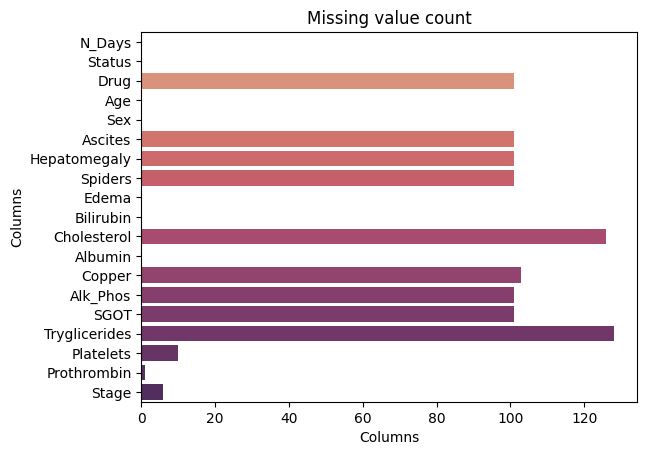

In [11]:
a = cir.isna().sum()
sns.barplot(y=a.index, x=a.values,palette="flare")
plt.title("Missing value count")
plt.xlabel("Columns")
plt.ylabel("Columns")

We got too many null values. Looking at number of rows, its not feasible to drop rows containing null values.

In [12]:
cir[cir["Stage"].isna()]

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
312,4062,C,NaN,60.041096,F,NaN,NaN,NaN,N,0.7,NaN,3.65,NaN,NaN,NaN,NaN,378.0,11.0,NaN
316,3030,C,NaN,62.043836,F,NaN,NaN,NaN,N,0.8,NaN,2.48,NaN,NaN,NaN,NaN,273.0,10.0,NaN
318,41,D,NaN,46.032877,F,NaN,NaN,NaN,N,5.0,NaN,2.93,NaN,NaN,NaN,NaN,260.0,10.4,NaN
321,2011,D,NaN,64.043836,F,NaN,NaN,NaN,N,1.1,NaN,3.69,NaN,NaN,NaN,NaN,139.0,10.5,NaN
333,466,D,NaN,56.038356,F,NaN,NaN,NaN,N,7.1,NaN,3.51,NaN,NaN,NaN,NaN,721.0,11.8,NaN
336,2286,D,NaN,56.038356,F,NaN,NaN,NaN,N,1.8,NaN,3.64,NaN,NaN,NaN,NaN,141.0,10.0,NaN


With too many missing values in rows where the target value is also missing, so lets drop rows with missing target value.

In [13]:
#drop rows with missing target(stage) value
cir.dropna(axis=0,subset=["Stage"],inplace=True)

In [14]:
cir["Stage"] = cir["Stage"].astype(int)

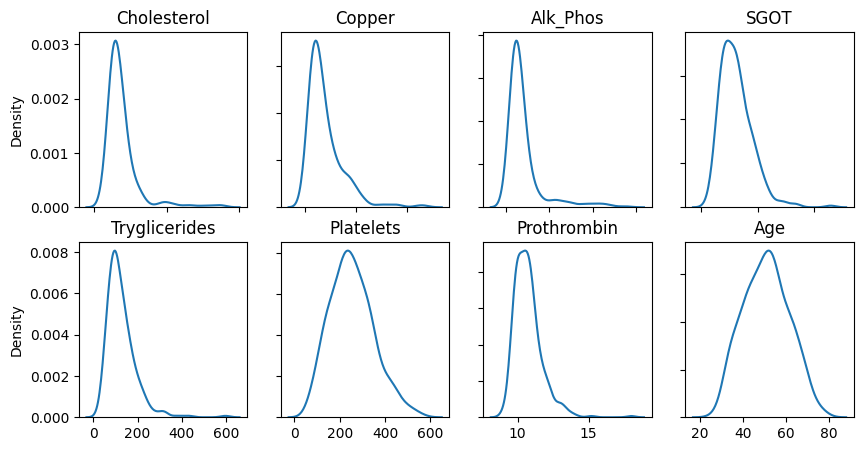

<Figure size 1200x800 with 0 Axes>

In [15]:
#checking data distributions for numerical features
#age doesn't have missing values, used here just to balance subplot
missing_nums = [["Cholesterol","Copper","Alk_Phos","SGOT"],["Tryglicerides","Platelets","Prothrombin","Age"]]
fig, axs = plt.subplots(2, 4,figsize=(10,5))
plt.figure(figsize=(12,8))
for i in range(2):
  for j in range(4):
    sns.kdeplot(cir,x=missing_nums[i][j], ax=axs[i,j])
    axs[i,j].label_outer()
    axs[i,j].set_xlabel('', fontsize=15)
    axs[i,j].set_title(missing_nums[i][j])
plt.show()

All the numerical features with missing values follows gaussian distributiom with some degree of skewness, so lets use median to impute missing values in those colums.
Also, some outlier can be seen, to fix skewness and outliers we will use log transformation(natural log being it a medical dataset)

In [16]:
#impute numerical values with median
numerical_columns = cir.select_dtypes(include=(['int64', 'float64'])).columns

for c in numerical_columns:
    if c!="Stage":cir[c] = np.log(cir[c]) #log transformation to remove outliers
    cir[c].fillna(cir[c].median(), inplace=True)

In [17]:
categorical_columns = cir.select_dtypes(include=('object')).columns

for c in categorical_columns:
    cir[c].fillna(cir[c].mode().values[0], inplace=True)

# Data Visualization
Data vizualization is done in detail in another notebook.
https://github.com/rupeshghimire7/Cirrhosis_EDA

Text(0.5, 1.0, 'Sex wise cirrhosis stages')

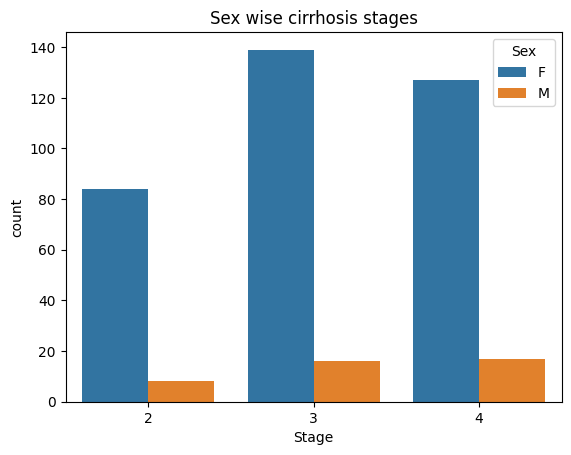

In [18]:
sns.countplot(x='Stage', hue='Sex', data=cir)
plt.title("Sex wise cirrhosis stages")

It's clear that female aremore prone to liver cirrhosis at any stage
One of the most common causes of liver cirrhosis is chronic alcohol consumption, and women may be more susceptible to alcohol-related liver damage than men. This is because women tend to have lower levels of an enzyme called alcohol dehydrogenase, which is involved in metabolizing alcohol. As a result, women may experience more severe liver damage from the same amount of alcohol consumption as men.

But due to almost same number of cases in all stages for both male and female, this feature might not be the best one to predict cirrhosis stage.

<Axes: xlabel='Stage', ylabel='count'>

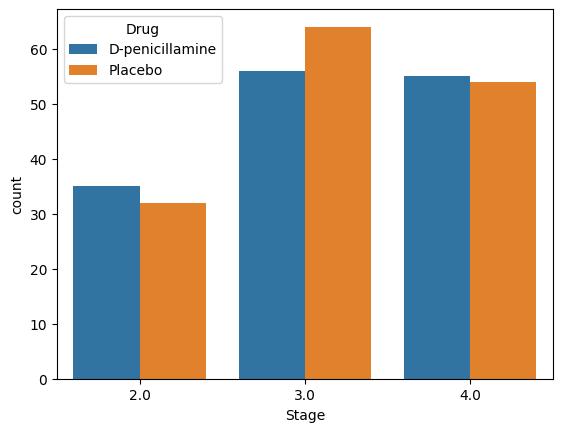

In [ ]:
sns.countplot(x='Stage', hue='Drug', data=cir)

#Column Encoding



We have some categorical columns with string values.Many ML algorithms couldn't work with such values. So, lets use appropriate encoding to encode them. We should have used two types of encoding as below.
One hot Encoding : Drugs,Sex
Label Encoding : Status,Ascites, Hepatomegaly, Spiders, Edema

But, even in the column "Sex", some ordinal relation can be seen, so its also encoded using label encoder.
Also, the drug is label encoded based on their strength.
A placebo is a substance or treatment that has no therapeutic effect. Placebo drugs are often used in medical research to help determine the effectiveness of a new treatment by comparing it to the placebo.

Whereas D-penicillamine is used to balance excess body parameters like copper.

In [ ]:
cir['Sex'] = cir['Sex'].replace({'M':0, 'F':1})
cir['Ascites'] = cir['Ascites'].replace({'N':0, 'Y':1})
cir['Drug'] = cir['Drug'].replace({'D-penicillamine':1, 'Placebo':0})
cir['Hepatomegaly'] = cir['Hepatomegaly'].replace({'N':0, 'Y':1})
cir['Spiders'] = cir['Spiders'].replace({'N':0, 'Y':1})
cir['Edema'] = cir['Edema'].replace({'N':0, 'Y':1, 'S':-1})
cir['Status'] = cir['Status'].replace({'C':0, 'CL':1, 'D':-1})

# cir['Stage'] = cir['Stage'].replace({2:0,3:1,4:2})
# cir['Stage'] = cir['Stage'].replace({1:0,2:1,3:2,4:3})

## Dataset balancing

First, we will check number of samples in our dataset for each stage of liver cirrhosis.

In [ ]:
def plot_target_count(data):
  """Function to plot number of samples in each class"""

  plt.figure(figsize=(4,4))
  counts = data.value_counts()

  plt.bar(x = counts.index, height = counts, color = 'orange')
  plt.xticks(rotation = 90)
  plt.title('Target Counts')
  plt.xlabel('Stages')
  plt.ylabel('Counts')
  plt.xticks([2,3,4], ['Stage 2', 'Stage 3', 'Stage 4'], rotation = 0)
  plt.show()

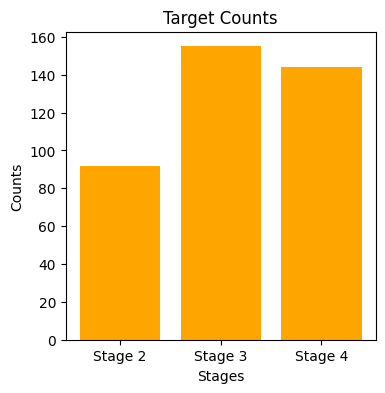

In [ ]:
plot_target_count(cir["Stage"])

The dataset is  imbalanced with less number of rows for earlier stage of cirrhosis. We will perform oversampling using SMOTE(Synthetic Minority Oversampling Technique).

Before performing oversamling we will split our existing dataset into train and test set. We will use 80-20 split for train and test set.

In [ ]:
# separate features and target
X = cir.drop(['Status', 'Stage'], axis=1)
y = cir['Stage']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

In [ ]:
#Using Smote for upsampling
sm = SMOTE(k_neighbors = 3)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
X_train.shape,y_train.shape

((363, 17), (363,))

# Feature Scaling

As we saw before, the numerical columns have varying range, so we will perform feature selection to scale them.

We will experiment with two kind of scaler: StandardScaler and MinMax Scaler.

In [ ]:
# Using standard Scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# # Using MinMax Scaler
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

## Feature Selection
 Our dataset
has a comparatively more number of features considering the number of records. So, in order to
select the best feature, we will use a statistical method called the ANOVA test.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
best = SelectKBest( score_func = f_classif, k = 12)
best.fit(X_train,y_train)

SelectKBest(k=12)

In [ ]:
best_cols = best.get_support(indices=True)
best_cols

array([ 0,  2,  4,  5,  6,  8,  9, 10, 11, 14, 15, 16])

In [ ]:
best_train = X_train[:,best_cols]
best_test = X_test[:,best_cols]

In [ ]:
scores = best.scores_
pvalues = best.pvalues_
cols = X.columns
for idx in range(X.shape[1]):
  print(cols[idx],scores[idx])

N_Days 33.19016021764813
Drug 0.45331266950794397
Age 7.74342961736615
Sex 0.38883349950149676
Ascites 13.60301034807157
Hepatomegaly 25.26663728514767
Spiders 12.396694214876035
Edema 0.5702217529039068
Bilirubin 17.330413109420693
Cholesterol 3.6378360850674127
Albumin 27.376560677171554
Copper 8.390251674969612
Alk_Phos 0.31102125050320323
SGOT 1.0663305808671784
Tryglicerides 2.8523765755746213
Platelets 12.399604097001152
Prothrombin 27.301199100205487


Text(0, 0.5, 'Features')

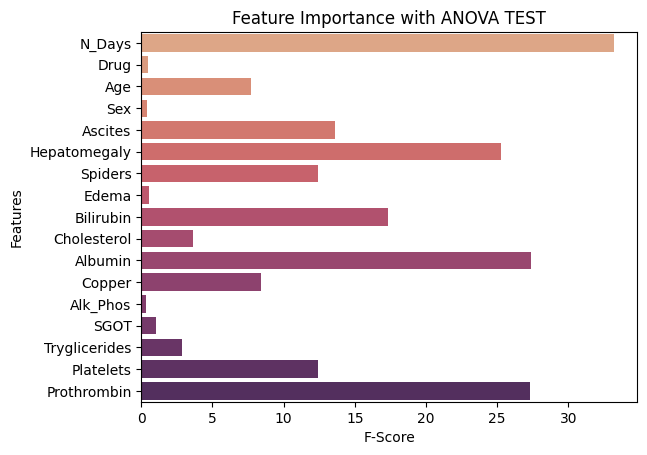

In [ ]:
sns.barplot(y=cols,x=scores,palette="flare")
plt.title("Feature Importance with ANOVA TEST")
plt.xlabel("F-Score")
plt.ylabel("Features")

## Setup MLFlow

In [ ]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

In [ ]:
%env ML_FLOW_EXP=<place you databrick experiment uri string here>

In [ ]:
import os
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(os.environ['ML_FLOW_EXP'])

In [ ]:
#function to track experiment results with mlflow
def mlflow_track(model,exp_name,train_scores,test_scores):
  #set name of experiment
  params = model.get_params()#

  with mlflow.start_run(run_name=exp_name):
    mlflow.log_metric("recall_train", train_scores[0])
    mlflow.log_metric("precision_train", train_scores[1])
    mlflow.log_metric("f1_train", train_scores[2])
    mlflow.log_metric("accuracy_train", train_scores[3])
    mlflow.log_metric("recall_test", test_scores[0])
    mlflow.log_metric("precision_test", test_scores[1])
    mlflow.log_metric("f1_test", test_scores[2])
    mlflow.log_metric("accuracy_test", test_scores[3])
    mlflow.log_params(params)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score,classification_report

In [ ]:
def evaluate_model(y_train,y_pred_train,y_test,y_pred_test):
  print("-"*30,"FOR TRAIN SET","-"*30)
  recall_train = recall_score(y_train,y_pred_train,average="macro")
  precision_train = precision_score(y_train,y_pred_train,average="macro")
  f1_train = f1_score(y_train,y_pred_train,average="macro")
  accuracy_train = accuracy_score(y_train,y_pred_train)
  rep_train = classification_report(y_train,y_pred_train)
  print(rep_train)
  
  print("-"*30,"FOR TEST SET","-"*30)
  recall_test = recall_score(y_test,y_pred_test,average="macro")
  precision_test = precision_score(y_test,y_pred_test,average="macro")
  f1_test = f1_score(y_test,y_pred_test,average="macro")
  accuracy_test = accuracy_score(y_test,y_pred_test)
  rep_test = classification_report(y_test,y_pred_test)
  print(rep_test)
  return (recall_train,precision_train,f1_train,accuracy_train), (recall_test,precision_test,f1_test,accuracy_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
log_reg = LogisticRegression(max_iter=500,random_state=28)
log_reg.fit(best_train, y_train)

log_pred = log_reg.predict(best_test)
log_pred_train = log_reg.predict(best_train)
 
train_scores,test_scores = evaluate_model(y_train,log_pred_train,y_test,log_pred)
mlflow_track(log_reg,"logistic_reg-500iter",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.57      0.64      0.61       121
           3       0.49      0.37      0.42       121
           4       0.62      0.70      0.66       121

    accuracy                           0.57       363
   macro avg       0.56      0.57      0.56       363
weighted avg       0.56      0.57      0.56       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.30      0.44      0.36        16
           3       0.58      0.44      0.50        34
           4       0.63      0.66      0.64        29

    accuracy                           0.52        79
   macro avg       0.50      0.51      0.50        79
weighted avg       0.54      0.52      0.52        79



In [ ]:
dt = DecisionTreeClassifier(criterion="log_loss",max_depth=50,random_state=20)
dt.fit(best_train, y_train)

dt_pred = dt.predict(best_test)
dt_pred_train = dt.predict(best_train)

train_scores,test_scores = evaluate_model(y_train,dt_pred_train,y_test,dt_pred)
mlflow_track(log_reg,"dtree",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       121
           3       1.00      1.00      1.00       121
           4       1.00      1.00      1.00       121

    accuracy                           1.00       363
   macro avg       1.00      1.00      1.00       363
weighted avg       1.00      1.00      1.00       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.19      0.19      0.19        16
           3       0.60      0.53      0.56        34
           4       0.48      0.55      0.52        29

    accuracy                           0.47        79
   macro avg       0.42      0.42      0.42        79
weighted avg       0.47      0.47      0.47        79



In [ ]:
rf = RandomForestClassifier(n_estimators=120,criterion="log_loss",max_depth=10,min_samples_leaf=4,random_state=20)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_pred_train = rf.predict(X_train)

train_scores,test_scores = evaluate_model(y_train,rf_pred_train,y_test,rf_pred)
mlflow_track(rf,"rf-log_loss",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.95      0.91      0.93       121
           3       0.93      0.93      0.93       121
           4       0.90      0.93      0.92       121

    accuracy                           0.93       363
   macro avg       0.93      0.93      0.93       363
weighted avg       0.93      0.93      0.93       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.30      0.38      0.33        16
           3       0.67      0.53      0.59        34
           4       0.72      0.79      0.75        29

    accuracy                           0.59        79
   macro avg       0.56      0.57      0.56        79
weighted avg       0.61      0.59      0.60        79



In [ ]:
rf = RandomForestClassifier(n_estimators=25,criterion="log_loss",max_depth=25,min_samples_leaf=4,random_state=20)
# rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_pred_train = rf.predict(X_train)

train_scores,test_scores = evaluate_model(y_train,rf_pred_train,y_test,rf_pred)
mlflow_track(rf,"rf2",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.92      0.88      0.90       121
           3       0.90      0.92      0.91       121
           4       0.90      0.93      0.91       121

    accuracy                           0.91       363
   macro avg       0.91      0.91      0.91       363
weighted avg       0.91      0.91      0.91       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.27      0.38      0.32        16
           3       0.68      0.50      0.58        34
           4       0.62      0.69      0.66        29

    accuracy                           0.54        79
   macro avg       0.53      0.52      0.52        79
weighted avg       0.58      0.54      0.55        79



In [ ]:
bag = BaggingClassifier(rf,bootstrap_features=True,random_state=22)
bag.fit(X_train, y_train)

bag_pred = bag.predict(X_test)
bag_pred_train = bag.predict(X_train)

train_scores,test_scores = evaluate_model(y_train,bag_pred_train,y_test,bag_pred)
mlflow_track(bag,"bagging-rf",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.83      0.85      0.84       121
           3       0.85      0.78      0.81       121
           4       0.84      0.88      0.86       121

    accuracy                           0.84       363
   macro avg       0.84      0.84      0.84       363
weighted avg       0.84      0.84      0.84       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.39      0.44      0.41        16
           3       0.70      0.56      0.62        34
           4       0.68      0.79      0.73        29

    accuracy                           0.62        79
   macro avg       0.59      0.60      0.59        79
weighted avg       0.63      0.62      0.62        79



In [ ]:
bag_fs = BaggingClassifier(rf,bootstrap_features=True,random_state=22)
bag_fs.fit(best_train, y_train)

bag_fs_pred = bag_fs.predict(best_test)
bag_fs_pred_train = bag_fs.predict(best_train)

train_scores,test_scores = evaluate_model(y_train,bag_fs_pred_train,y_test,bag_fs_pred)
mlflow_track(bag,"bagging-rf featSel",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.78      0.85      0.81       121
           3       0.84      0.71      0.77       121
           4       0.80      0.85      0.82       121

    accuracy                           0.80       363
   macro avg       0.81      0.80      0.80       363
weighted avg       0.81      0.80      0.80       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.29      0.44      0.35        16
           3       0.57      0.35      0.44        34
           4       0.71      0.83      0.76        29

    accuracy                           0.54        79
   macro avg       0.52      0.54      0.52        79
weighted avg       0.56      0.54      0.54        79



In [ ]:
ada = AdaBoostClassifier(n_estimators=50,random_state=20)
ada.fit(X_train, y_train)

ada_pred = ada.predict(X_test)
ada_pred_train = ada.predict(X_train)

train_scores,test_scores = evaluate_model(y_train,ada_pred_train,y_test,ada_pred)
mlflow_track(ada,"ada boost1",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.67      0.70      0.69       121
           3       0.61      0.64      0.62       121
           4       0.77      0.70      0.74       121

    accuracy                           0.68       363
   macro avg       0.68      0.68      0.68       363
weighted avg       0.68      0.68      0.68       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.38      0.38      0.38        16
           3       0.66      0.68      0.67        34
           4       0.68      0.66      0.67        29

    accuracy                           0.61        79
   macro avg       0.57      0.57      0.57        79
weighted avg       0.61      0.61      0.61        79



In [ ]:
ada = AdaBoostClassifier(random_state=28)
ada.fit(best_train, y_train)

ada_pred = ada.predict(best_test)
ada_pred_train = ada.predict(best_train)

train_scores,test_scores  = evaluate_model(y_train,ada_pred_train,y_test,ada_pred)
mlflow_track(ada,"ada boost2- featSel",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.71      0.68      0.69       121
           3       0.63      0.61      0.62       121
           4       0.73      0.79      0.76       121

    accuracy                           0.69       363
   macro avg       0.69      0.69      0.69       363
weighted avg       0.69      0.69      0.69       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.50      0.56      0.53        16
           3       0.66      0.68      0.67        34
           4       0.77      0.69      0.73        29

    accuracy                           0.66        79
   macro avg       0.64      0.64      0.64        79
weighted avg       0.67      0.66      0.66        79



In [ ]:
svm = SVC(kernel="rbf")
svm.fit(best_train, y_train)

svm_pred = svm.predict(best_test)
svm_pred_train = svm.predict(best_train)

train_scores,test_scores = evaluate_model(y_train,svm_pred_train,y_test,svm_pred)
mlflow_track(svm,"svm-feat sel",train_scores,test_scores)

------------------------------ FOR TRAIN SET ------------------------------
              precision    recall  f1-score   support

           2       0.68      0.74      0.71       121
           3       0.70      0.61      0.65       121
           4       0.77      0.80      0.79       121

    accuracy                           0.72       363
   macro avg       0.72      0.72      0.71       363
weighted avg       0.72      0.72      0.71       363

------------------------------ FOR TEST SET ------------------------------
              precision    recall  f1-score   support

           2       0.30      0.44      0.36        16
           3       0.56      0.44      0.49        34
           4       0.69      0.69      0.69        29

    accuracy                           0.53        79
   macro avg       0.52      0.52      0.51        79
weighted avg       0.55      0.53      0.54        79



Manual hypermeter tuning was done in most of these models.

## CONCLUSION

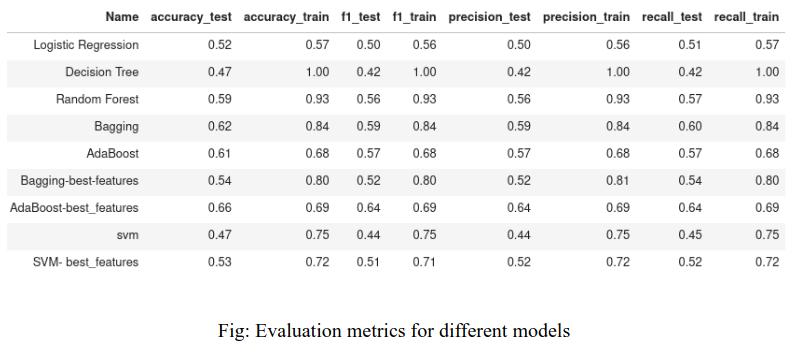

The results of our liver cirrhosis stage prediction models were not very promising, with the best recall score of 69% on the train test and 64% for the test set with AdaBoost with decision tree model. Our model was trained on a dataset of 369 records, with each patient's data including age,
gender and biomarkers from liver function test results.We used a variety of machine learning algorithms, including decision trees, random forests, bagging, adaboosting and support vector machines to build our prediction model. These results were obtained with only 3 stages after dropping records for stage 1 which is a normal healthy liver. 

The best obtained for stage 2, stage 3 and stage 4 are 56%,68% and 69% respectively. The higher
recall for irreversible state is a good point, but the results are not sufficient to be used in a real
world setting. The later stage of liver cirrhosis can be diagnosed easily with simple tests. So, the
automated predictive system must be capable of detecting them at an earlier stage too.
For this, we need to collect more consistent data which contains cases of earlier stage of cirrhosis
too. Also, the use of more complex models like Neural Networks would definitely improve the
results.